In [1]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing

# Airfoil

(-0.05, 1.05, -0.049713357925077785, 0.12146580378039586)

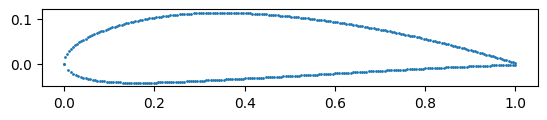

In [2]:
airfoil = af.Airfoil.NACA4("4415", n_points=200)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

# Air

In [3]:
dens = 1.2
alpha0 = -4 * np.pi / 180

In [4]:
Umag = 20
alpha = 5 * np.pi/180
beta = 0
Uinf = Umag * np.cos(alpha) * np.cos(beta)
Vinf = Umag * np.cos(alpha) * np.sin(beta)
Winf = Umag * np.sin(alpha) * np.cos(beta)
Qinf = np.array((Uinf, Vinf, Winf))


# Wing Geometry

In [5]:
# Discretization
N = 50
M = 3

In [6]:
span = 6
spanDist = np.linspace(0, span, N)
chordDist = np.ones(N)
diheDist = np.zeros(N)
sweepDist = np.hstack((np.linspace(1,0,int(N/2)) , np.linspace(0,1,int(N/2))))
wakeDist = 20 * chordDist
betaWake = 20 * chordDist * np.sin(beta)

# Slanted Wake Horseshoe

We are trying to model figure (a)
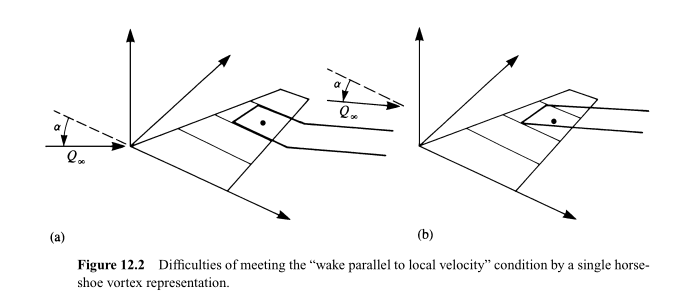

## Discretization

panels (50, 3, 3)


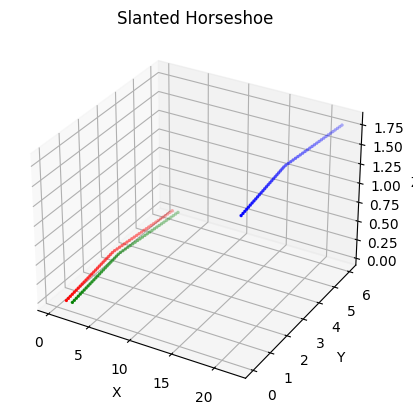

In [7]:
%matplotlib inline
xs = np.empty((M, N))
ys = np.empty((M, N))
zs = np.empty((M, N))

xs[0, :] = sweepDist + chordDist/4
xs[1, :] = sweepDist + chordDist
xs[2, :] = xs[1, :] + wakeDist

ys[0, :] = spanDist 
ys[1, :] = spanDist 
ys[2, :] = spanDist + betaWake

zs[0, :] = diheDist + airfoil.camber_line(chordDist / 4)
zs[1, :] = diheDist + airfoil.camber_line(chordDist/ 4) 
zs[2, :] = zs[1, :] + wakeDist * np.sin(alpha)

panels = np.array((xs, ys, zs)).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xs[0,:], ys[0,:], zs[0,:], marker='.', color = 'r',linewidths=0.1)
ax.scatter(xs[1,:], ys[1,:], zs[1,:], marker='.', color = 'g',linewidths=0.1)
ax.scatter(xs[2,:], ys[2,:], zs[2,:], marker='.', color = 'b',linewidths=0.1)

ax.set_title("Slanted Horseshoe")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
print(f"panels {panels.shape}")

In [8]:
panels.shape

(50, 3, 3)

In [9]:
nj = np.repeat([(np.sin(alpha) * np.cos(beta),
                 np.cos(alpha) * np.sin(beta),
                 np.cos(alpha) * np.cos(beta))], (N-1)*(M-1), axis=0)

## Solve

In [10]:
a = np.zeros(((N-1)*(M-2), (N-1)*(M-2)))
infMat = np.zeros(((N-1)*(M-2), (N-1)*(M-2)))

RHS = np.zeros((N-1)*(M-2))
w_ind = np.zeros((N-1,3))
L_pan = np.zeros((N-1))
D_pan = np.zeros((N-1))

k = 0
for i in np.arange(0, N-1):
    RHS[i] = np.pi * (alpha - alpha0) * chordDist[i] * Umag
    for j in np.arange(0, N-1):
        U, Ustar = pot.hshoeSL((xs[0, i] + xs[0, i+1])/2,
                           (ys[0, i] + ys[0, i+1])/2,
                           (zs[0, i] + zs[0, i+1])/2,
                           k,j, panels)
        a[i, j] = np.dot(nj[i],U) 
        infMat[i,j] = - a[i, j] * chordDist[i] * np.pi
    infMat[i, i] = infMat[i, i] + 1

Gammas = np.linalg.solve(infMat, RHS)
w_ind = np.matmul(a,Gammas)

for i in np.arange(0, N-1):
    L_pan[i] =  dens * Umag  * Gammas[i] * (ys[0, i+1] - ys[0, i])
    D_pan[i] = - dens * w_ind[i] * Gammas[i] * (ys[0, i+1] - ys[0, i])
L_SL = np.sum(L_pan,axis=0)
D_SL = np.sum(D_pan)

IndexError: index 3 is out of bounds for axis 2 with size 3

In [84]:
print(f'Lift is: {L_SL}\t|\tDrag is: {D_SL}')

Lift is: 446.2274427496523	|	Drag is: 8.896215905308571


/tmp/ipykernel_104540/729390518.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


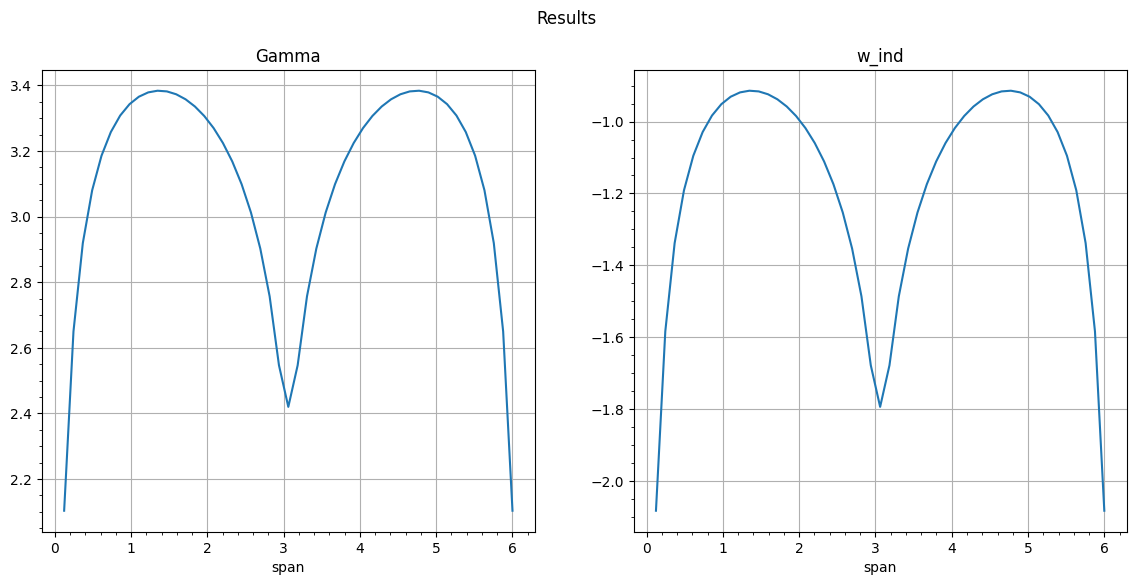

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (14,6))
fig.suptitle('Results')

ax1.plot(ys[0,1:],Gammas)
ax1.set_xlabel("span")
ax1.set_title("Gamma")
ax1.minorticks_on()
ax1.grid()

ax2.plot(ys[0,1:],(w_ind/Umag) * 180 / np.pi)
ax2.set_xlabel("span")
ax2.set_title("w_ind")
ax2.minorticks_on()
ax2.grid()
fig.show()